In [1]:
import sys
sys.path.append('..')
import copy

from star_spin_up import *

import struct

import pickle
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

In [2]:
# boilerplate code for pretty plots

from matplotlib import font_manager

font_path =  '/home/jsn/landing/fonts/IBMPlexMono-Regular.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = prop.get_name()

import matplotlib as mpl
from cycler import cycler

colo =["#4878D0", "#EE854A", "#6ACC64", "#D65F5F", "#956CB4","#8C613C", "#DC7EC0", "#797979", "#D5BB67", "#82C6E2"]

# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#4878D0", "#EE854A", "#6ACC64", "#D65F5F", "#956CB4","#8C613C", "#DC7EC0", "#797979", "#D5BB67", "#82C6E2"]) 

mpl.rcParams['image.origin'] = 'lower'

In [3]:
# reading in the output file
# output file is in binary format to keep size down...
# roughly in the form:
# star 1 [frame 1, frame 2, frame 3, ...']
# star 2 [frame 1, frame 2, frame 3, ...']
# star 3 [frame 1, frame 2, frame 3, ...']
# sequentially read each star's time series history
# iterate over the history length, then number of stars

def read_stars_dat(filename):
    with open(filename,'rb') as f:

        n_iter = struct.unpack('>I', f.read(4))[0] # number of iterations
        dt = struct.unpack('>d', f.read(8))[0] # timestep
        n_stars = struct.unpack('>I', f.read(4))[0] # total number of stars
        
        star_times_series = []
        for _ in range(n_stars):            
            frame = []
            # number of iterations includes the last frame so +1
            for _ in range(n_iter+1):
                s = {}
                s['age'] = (struct.unpack('>d', f.read(8))[0])
                s['mass'] = (struct.unpack('>d', f.read(8))[0])
                s['radius'] = (struct.unpack('>d', f.read(8))[0])
                s['inertia'] = (struct.unpack('>d', f.read(8))[0])
                s['period'] = (struct.unpack('>d', f.read(8))[0])
                s['rot_vel'] = (struct.unpack('>d', f.read(8))[0])
                s['ang_mom'] = (struct.unpack('>d', f.read(8))[0])
                frame.append(s)
            star_times_series.append(frame)

    return n_iter, dt, n_stars, star_times_series

In [4]:
# this is gonna take a while for huge files...
filename = '../stars.dat'
n_iter, dt, n_stars, star_times_series = read_stars_dat(filename)
times = np.linspace(0, dt*n_iter, n_iter+1) # can derive the times from the parameters of the simulation

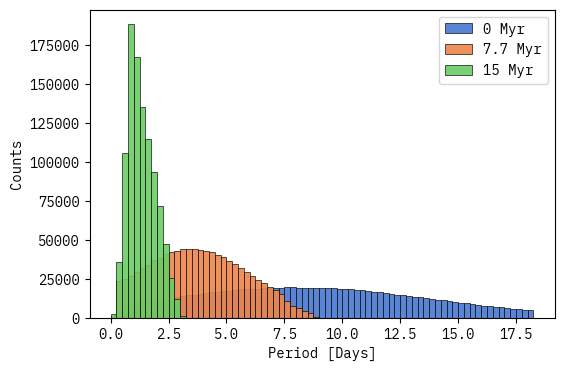

In [5]:
initial_periods = [star[0]['period']*365 for star in star_times_series] # initial period dist at 0 Myr
mid_periods = [star[10]['period']*365 for star in star_times_series] # intermediary period dist at 7.7 Myr
final_periods = [star[len(star)//2]['period']*365 for star in star_times_series] # final period dist at 15 Myr

bins = np.arange(0,18.5,0.25) # period bins

# make period distribution plots
fig, ax = plt.subplots(figsize=(6,4))

ax.hist(initial_periods, bins=bins, edgecolor='black', linewidth=0.5, label='0 Myr', alpha=0.9)
ax.hist(mid_periods, bins=bins, edgecolor='black', linewidth=0.5, label='7.7 Myr', alpha=0.9)
ax.hist(final_periods, bins=bins, edgecolor='black', linewidth=0.5, label = '15 Myr', alpha=0.9)

ax.set_xlabel('Period [Days]')
ax.set_ylabel('Counts')

ax.legend()

plt.savefig('period_dist.pdf', bbox_inches='tight')
plt.show()

In [6]:
# nice stats for paper
print('7.7 Myr | Mean -> {:.3f} days STD -> {:.3f} days'.format(np.mean(mid_periods), np.std(mid_periods)))
print('15  Myr | Mean -> {:.3f} days STD -> {:.3f} days'.format(np.mean(final_periods), np.std(final_periods)))

7.7 Myr | Mean -> 3.818 days STD -> 1.963 days
15  Myr | Mean -> 1.352 days STD -> 0.578 days


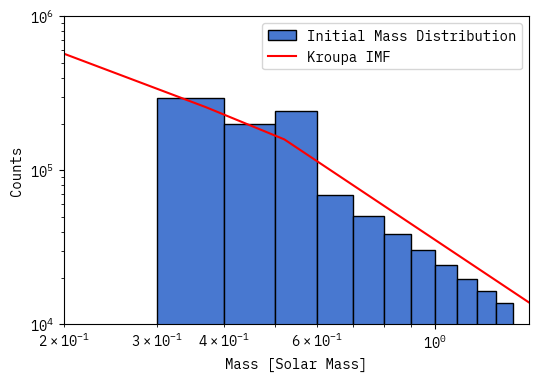

In [7]:
# calculate the IMF in a nice numpy vectorized form
v_imf = np.vectorize(imf_kroupa2013_unnorm, otypes=[float])

# load the norm...
with open('../kroupa2013_norm.pickle', 'rb') as f:
    norm = pickle.load(f)

# plot the IMF over the entire mass range
masses = np.linspace(0.07, 150, 1000)
pdf = v_imf(masses)/norm # don't forget to normalize!

mass_distribution = [star[0]['mass'] for star in star_times_series]
bins = np.arange(0.3,1.4+0.1,0.1)

fig, ax = plt.subplots(figsize=(6,4))

ax.hist(mass_distribution, bins=bins, edgecolor='black', linewidth=1, label='Initial Mass Distribution')
arb_scaling = 3e5 # scale arbitrarily to make plot nice
ax.plot(masses, arb_scaling*pdf, color='red', label='Kroupa IMF')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(0.2, 1.5)
ax.set_ylim(1e4, 1e6)

ax.set_xlabel('Mass [Solar Mass]')
ax.set_ylabel('Counts')

ax.legend()

plt.savefig('imf.pdf', bbox_inches='tight')
plt.show()

In [8]:
star_times_series[0][0].keys() # see all available keys

dict_keys(['age', 'mass', 'radius', 'inertia', 'period', 'rot_vel', 'ang_mom'])

In [9]:
# select some particular masses and find their first occurence in the star_times_series array
# the masses are randomly seeded, but we only need one of each for this example

selected_masses = [0.3, 0.7, 1, 1.4]
indices = []

for sm in selected_masses:
    for i, sts in enumerate(star_times_series):

        mass = sts[0]['mass']
        if mass == sm:
            print('Mass: {:.2f}, Index {:d}'.format(sm, i))
            indices.append(i)
            break

Mass: 0.30, Index 4
Mass: 0.70, Index 5
Mass: 1.00, Index 2
Mass: 1.40, Index 143


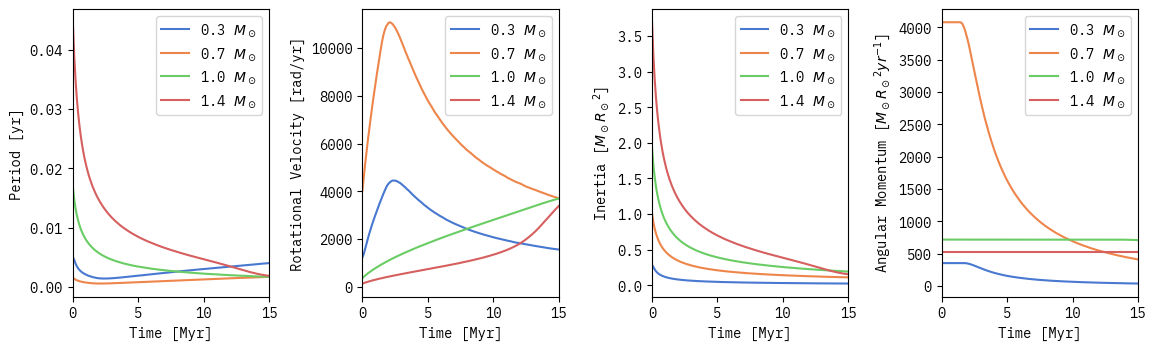

In [10]:
# now plot the period, rotational velocity, inertia, and angular momentum of each of these

fig, axs = plt.subplots(1, 4, figsize=(12,4))
fig.tight_layout(pad=3.0)

for sm,i in zip(selected_masses,indices):
    val = [el['period'] for el in star_times_series[i]]
    axs[0].plot(times/1e6,val, label='{:.1f} $M_\odot$'.format(sm))
    axs[0].set_xlim(0, 15)
    axs[0].set_xlabel('Time [Myr]')
    axs[0].set_ylabel('Period [yr]')
    axs[0].grid()
    axs[0].legend()

    val = [el['rot_vel'] for el in star_times_series[i]]
    axs[1].plot(times/1e6,val, label='{:.1f} $M_\odot$'.format(sm))
    axs[1].set_xlim(0, 15)
    axs[1].set_xlabel('Time [Myr]')
    axs[1].set_ylabel('Rotational Velocity [rad/yr]')
    axs[1].grid()
    axs[1].legend()

    val = [el['inertia'] for el in star_times_series[i]]
    axs[2].plot(times/1e6,val, label='{:.1f} $M_\odot$'.format(sm))
    axs[2].set_xlim(0, 15)
    axs[2].set_xlabel('Time [Myr]')
    axs[2].set_ylabel('Inertia [$M_\odot {R_\odot}^2$]')
    axs[2].grid()
    axs[2].legend()

    val = [el['ang_mom'] for el in star_times_series[i]]
    axs[3].plot(times/1e6,val, label='{:.1f} $M_\odot$'.format(sm))
    axs[3].set_xlim(0, 15)
    axs[3].set_xlabel('Time [Myr]')
    axs[3].set_ylabel('Angular Momentum [$M_\odot {R_\odot}^2 yr^{-1}$]')
    axs[3].grid()
    axs[3].legend()

plt.savefig('ex_star.pdf', bbox_inches='tight')

plt.show()